**Diana Kim ADA-2403M**

# **Assignment 4**
**Тема:** Гибридные и распределённые параллельные вычисления


In [1]:
!nvidia-smi

Sat Jan 24 11:52:36 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


### **Задание 1**




In [27]:
%%writefile cpu.cpp

#include <iostream>      // подключает ввод и вывод
#include <vector>      // подключает контейнер vector
#include <chrono>        // подключает работу со временем
using namespace std;          // чтобы не писать std::



int main() {
    int N = 100000;    // размер массива
    vector<int> arr(N);          // создает массив из N элементов
    for (int i = 0; i < N; i++) {              // один поток заполняет массив
        arr[i] = 1;                 // каждому элементу присваивается значение 1
    }
    long long sum = 0;             // переменная для хранения суммы
    auto start = chrono::high_resolution_clock::now();           // запоминает время начала
    for (int i = 0; i < N; i++) {            // один поток проходит по массиву
        sum += arr[i];            // добавляет текущий элемент к сумме
    }
    auto end = chrono::high_resolution_clock::now();           // запоминает время конца
    auto duration = chrono::duration_cast<chrono::microseconds>(end - start);            // считает время выполнения

    cout << "CPU sum = " << sum << endl;           // выводит сумму
    cout << "CPU time = " << duration.count() << endl;          // выводит время в микросек

    return 0;             // завершает программу
}

Overwriting cpu.cpp


In [32]:
!g++ cpu.cpp -O2 -o cpu
!./cpu

CPU sum = 100000
CPU time = 65


In [29]:
%%writefile gpu.cu

#include <iostream>          // подключает ввод и вывод
#include <cuda_runtime.h>          // подключает CUDA
#include <chrono>              // подключает работу со временем
using namespace std; // чтобы не писать std::



__global__ void kernel_double(int* arr, int N) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;             // индекс потока

    if (idx < N) {           // проверка границы
        arr[idx] = 2;              // GPU меняет элемент массива
    }
}



int main() {
    int N = 100000;        // размер массива
    int* arr;            // массив в unified memory
    cudaMallocManaged(&arr, N * sizeof(int));        // выделяет память

    for (int i = 0; i < N; i++) {           // CPU заполняет массив
        arr[i] = 1;          // значение 1
    }
    int threadsPerBlock = 256;            // потоков в блоке
    int blocksPerGrid = (N + threadsPerBlock - 1) / threadsPerBlock;              // количество блоков
    auto start = chrono::high_resolution_clock::now();                 // старт времени
    kernel_double<<<blocksPerGrid, threadsPerBlock>>>(arr, N);            // запуск kernel
    cudaDeviceSynchronize();            // ждёт GPU
    auto end = chrono::high_resolution_clock::now();            // конец времени
    int sum = 0;               // сумма на CPU
    for (int i = 0; i < N; i++) {             // CPU считает сумму
        sum += arr[i];          // суммирует элементы
    }
    auto duration = chrono::duration_cast<chrono::microseconds>(end - start);          // время

    cout << "GPU sum = " << sum << endl;           // вывод суммы
    cout << "GPU time = " << duration.count() << endl;          // вывод времени в микросек

    cudaFree(arr);           // освобождает память
    return 0;           // завершение
}

Overwriting gpu.cu


In [30]:
!nvcc gpu.cu -o gpu
!./gpu

GPU sum = 100000
GPU time = 7961


### Сравнение

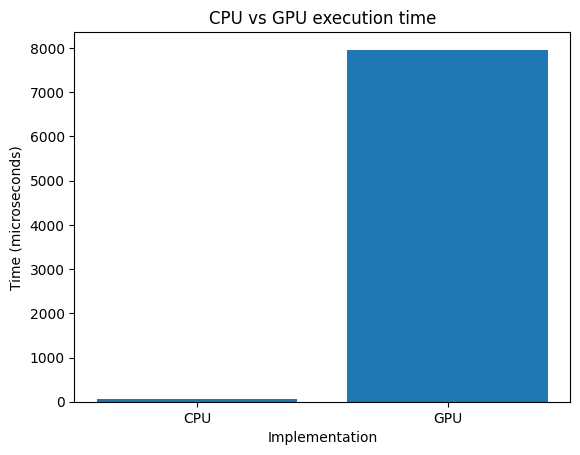

In [34]:
import matplotlib.pyplot as plt  # для построения графиков

cpu_time = 65  # время CPU в микросекундах
gpu_time = 7961  # время GPU в микросекундах

labels = ["CPU", "GPU"]  # подписи по оси X
times = [cpu_time, gpu_time]  # значения времени

plt.figure()  # создаёт новый график
plt.bar(labels, times)  # строит столбчатый график
plt.xlabel("Implementation")  # подпись оси X
plt.ylabel("Time (microseconds)")  # подпись оси Y
plt.title("CPU vs GPU execution time")  # заголовок графика
plt.show()  # отображает график

### **Задание 2**


In [42]:
%%writefile task2.cu

#include <iostream>       // подключает ввод и вывод
#include <vector>         // подключает vector
#include <chrono>           // подключает время
#include <cuda_runtime.h>     // подключает CUDA
using namespace std;            // чтобы не писать std::



void cuda_ok(cudaError_t err, const char* msg) {            // функция проверки ошибок CUDA
    if (err != cudaSuccess) {             // если есть ошибка
        cout << "CUDA error (" << msg << "): " << cudaGetErrorString(err) << endl;            // печатает ошибку
        exit(1);             // завершает программу
    }
}

__global__ void scan_blocks_kernel(const int* in, int* out, int* block_sums, int N) {
    extern __shared__ int sh[];                         // shared memory для блока
    int tid = threadIdx.x;                        // номер потока внутри блока
    int gid = blockIdx.x * blockDim.x + threadIdx.x;                  // глобальный индекс
    int x = 0;                  // значение элемента
    if (gid < N) x = in[gid];                     // берёт элемент если он в пределах
    sh[tid] = x;           // кладёт в shared memory
    __syncthreads();                 // ждёт все потоки

    for (int offset = 1; offset < blockDim.x; offset *= 2) {              // шаг scan
        int val = 0;                 // значение слева
        if (tid >= offset) val = sh[tid - offset];              // читает слева
        __syncthreads();                  // гарантирует что все прочитали
        sh[tid] = sh[tid] + val;                      // обновляет свой элемент
        __syncthreads();                        // гарантирует что все обновили
    }

    if (gid < N) out[gid] = sh[tid];                   // пишет результат в глобальную память
    if (tid == blockDim.x - 1) block_sums[blockIdx.x] = sh[tid];                // сохраняет сумму блока
}

__global__ void add_offsets_kernel(int* out, const int* block_offsets, int N) {
    int gid = blockIdx.x * blockDim.x + threadIdx.x;                 // глобальный индекс
    if (gid < N) {                 // проверяет границу
        int offset = 0;                  // смещение
        if (blockIdx.x > 0) offset = block_offsets[blockIdx.x - 1];                   // сумма предыдущих блоков
        out[gid] = out[gid] + offset;                   // добавляет смещение
    }
}




int main() {
    int N = 1000000;               // размер массива
    vector<int> h_in(N);               // вход
    vector<int> h_cpu(N);            // scan на CPU
    vector<int> h_gpu(N);               // scan после GPU
    for (int i = 0; i < N; i++) {              // заполняет вход
        h_in[i] = 1;             // ставит 1
    }
    auto cpu_start = chrono::high_resolution_clock::now();              // старт CPU
    int run = 0;                 // накопительная сумма
    for (int i = 0; i < N; i++) {                // проходит по массиву
        run += h_in[i];               // добавляет
        h_cpu[i] = run;            // записывает префикс
    }

    auto cpu_end = chrono::high_resolution_clock::now();            // конец CPU
    auto cpu_time = chrono::duration_cast<chrono::microseconds>(cpu_end - cpu_start);           // время CPU
    int* d_in;           // вход на GPU
    int* d_out;              // выход на GPU
    int* d_block_sums;             // суммы блоков
    int* d_block_offsets;            // оффсеты блоков
    int threadsPerBlock = 256;           // потоки в блоке
    int blocksPerGrid = (N + threadsPerBlock - 1) / threadsPerBlock;             // блоки

    cuda_ok(cudaMalloc(&d_in, N * sizeof(int)), "cudaMalloc d_in");          // alloc вход
    cuda_ok(cudaMalloc(&d_out, N * sizeof(int)), "cudaMalloc d_out");             // alloc выход
    cuda_ok(cudaMalloc(&d_block_sums, blocksPerGrid * sizeof(int)), "cudaMalloc d_block_sums");            // alloc суммы блоков
    cuda_ok(cudaMalloc(&d_block_offsets, blocksPerGrid * sizeof(int)), "cudaMalloc d_block_offsets");           // alloc оффсеты блоков
    cuda_ok(cudaMemcpy(d_in, h_in.data(), N * sizeof(int), cudaMemcpyHostToDevice), "Memcpy H->D d_in");               // копирует вход
    cuda_ok(cudaMemset(d_out, 0, N * sizeof(int)), "Memset d_out");                        // обнуляет выход
    cuda_ok(cudaMemset(d_block_sums, 0, blocksPerGrid * sizeof(int)), "Memset d_block_sums");                    // обнуляет суммы блоков
    cuda_ok(cudaMemset(d_block_offsets, 0, blocksPerGrid * sizeof(int)), "Memset d_block_offsets");                    // обнуляет оффсеты
    cudaEvent_t e_start, e_end;                     // события времени
    cuda_ok(cudaEventCreate(&e_start), "EventCreate start");                 // создаёт старт
    cuda_ok(cudaEventCreate(&e_end), "EventCreate end");             // создаёт конец
    cuda_ok(cudaEventRecord(e_start), "EventRecord start");            // старт времени
    scan_blocks_kernel<<<blocksPerGrid, threadsPerBlock, threadsPerBlock * sizeof(int)>>>(d_in, d_out, d_block_sums, N);            // scan по блокам
    cuda_ok(cudaGetLastError(), "scan_blocks_kernel launch");             // проверяет запуск kernel
    cuda_ok(cudaDeviceSynchronize(), "scan_blocks_kernel sync");        // ждёт kernel
    vector<int> h_block_sums(blocksPerGrid);             // суммы блоков на CPU
    vector<int> h_block_offsets(blocksPerGrid);             // оффсеты на CPU
    cuda_ok(cudaMemcpy(h_block_sums.data(), d_block_sums, blocksPerGrid * sizeof(int), cudaMemcpyDeviceToHost), "Memcpy D->H block_sums");                 // копирует суммы блоков
    int block_run = 0; // накопительная сумма блоков
    for (int i = 0; i < blocksPerGrid; i++) {             // считает префикс по блокам
        block_run += h_block_sums[i];             // добавляет сумму блока
        h_block_offsets[i] = block_run;             // записывает оффсет
    }
    cuda_ok(cudaMemcpy(d_block_offsets, h_block_offsets.data(), blocksPerGrid * sizeof(int), cudaMemcpyHostToDevice), "Memcpy H->D block_offsets");          // копирует оффсеты
    add_offsets_kernel<<<blocksPerGrid, threadsPerBlock>>>(d_out, d_block_offsets, N);           // добавляет оффсеты
    cuda_ok(cudaGetLastError(), "add_offsets_kernel launch");          // проверяет запуск kernel
    cuda_ok(cudaDeviceSynchronize(), "add_offsets_kernel sync");           // ждёт kernel
    cuda_ok(cudaEventRecord(e_end), "EventRecord end");           // конец времени
    cuda_ok(cudaEventSynchronize(e_end), "EventSync end");                 // ждёт событие
    float gpu_ms = 0.0f;                      // время GPU
    cuda_ok(cudaEventElapsedTime(&gpu_ms, e_start, e_end), "ElapsedTime");                     // считает время
    cuda_ok(cudaMemcpy(h_gpu.data(), d_out, N * sizeof(int), cudaMemcpyDeviceToHost), "Memcpy D->H d_out");                   // копирует результат
    int ok = 1;            // флаг
    for (int i = 0; i < N; i++) {               // сравнение
        if (h_gpu[i] != h_cpu[i]) {         // если не совпало
            ok = 0;                     // fail
            break;                 // выход
        }
    }

    cout << "CPU time = " << cpu_time.count() << endl;              // печатает время CPU
    cout << "GPU time = " << gpu_ms << endl;            // печатает время GPU
    cout << "CPU vs GPU = " << (ok ? "good" : "fail") << endl;                   // печатает проверку
    cout << "Last element CPU = " << h_cpu[N - 1] << endl;                  // последний CPU
    cout << "Last element GPU = " << h_gpu[N - 1] << endl;                   // последний GPU

    cudaFree(d_in);             // free вход
    cudaFree(d_out);             // free выход
    cudaFree(d_block_sums);                // free суммы блоков
    cudaFree(d_block_offsets);          // free оффсеты блоков
    cudaEventDestroy(e_start);                // удалить event
    cudaEventDestroy(e_end);            // удалить event

    return 0; // конец
}

Overwriting task2.cu


In [43]:
%%bash
nvcc -O2 -gencode arch=compute_75,code=sm_75 task2.cu -o task2
./task2

CPU time = 754
GPU time = 0.300128
CPU vs GPU = good
Last element CPU = 1000000
Last element GPU = 1000000


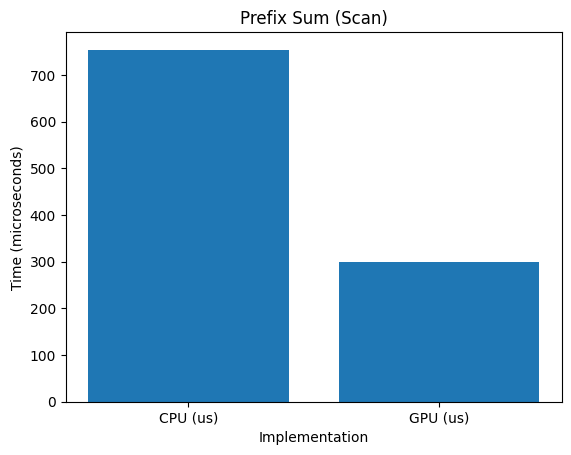

In [45]:
import matplotlib.pyplot as plt # библиотека для графиков

cpu_us = 754 # CPU time
gpu_ms = 0.300128 # GPU time

gpu_us = gpu_ms * 1000 # переводит миллисекунды в микросекунды

labels = ["CPU (us)", "GPU (us)"] # подписи столбиков
times = [cpu_us, gpu_us] # значения времени

plt.figure() # создаtт график
plt.bar(labels, times) # строит столбчатый график
plt.xlabel("Implementation") # подпись оси X
plt.ylabel("Time (microseconds)") # подпись оси Y
plt.title("Prefix Sum (Scan)") # заголовок
plt.show() # показывает график

### **Задание 3**


In [48]:
%%writefile task3.cu

#include <iostream>       // подключает ввод и вывод
#include <vector>         // подключает vector
#include <chrono>           // подключает время
#include <cuda_runtime.h>     // подключает CUDA
using namespace std;            // чтобы не писать std::


void cuda_ok(cudaError_t err, const char* msg) {         // проверка CUDA
    if (err != cudaSuccess) {
        cout << "CUDA error (" << msg << "): " << cudaGetErrorString(err) << endl;
        exit(1);
    }
}

__global__ void reduction_kernel(const int* in, int* block_sums, int N) {
    extern __shared__ int sh[];                // shared memory
    int tid = threadIdx.x;                  // поток в блоке
    int gid = blockIdx.x * blockDim.x + threadIdx.x;              // глобальный индекс
    int x = 0;                    // значение элемента
    if (gid < N) x = in[gid];                 // берет элемент если в пределах
    sh[tid] = x;               // кладет в shared memory
    __syncthreads();                     // ждет все потоки
    for (int stride = blockDim.x / 2; stride > 0; stride /= 2) {               // шаги редукции
        if (tid < stride) {                     // только половина потоков
            sh[tid] = sh[tid] + sh[tid + stride];                   // складывает элементы
        }
        __syncthreads();                    // синхронизация
    }

    if (tid == 0) block_sums[blockIdx.x] = sh[0];               // сохраняет сумму блока
}



int main() {
    int N = 1000000;            // задает размер массива
    vector<int> h_in(N);              // создает входной массив на CPU
    for (int i = 0; i < N; i++) {                // один поток CPU проходит по массиву
        h_in[i] = 1;              // заполняет каждый элемент единицей
    }


    auto cpu_start = chrono::high_resolution_clock::now();           // запоминает время начала CPU
    long long cpu_sum = 0;                 // создает переменную для суммы на CPU
    for (int i = 0; i < N; i++) {                 // один поток CPU проходит по массиву
        cpu_sum += h_in[i];                             // добавляет текущий элемент к сумме
    }
    auto cpu_end = chrono::high_resolution_clock::now();              // запоминает время конца CPU
    auto cpu_time = chrono::duration_cast<chrono::microseconds>(cpu_end - cpu_start);            // считает время CPU в микросекундах


    int* d_in;           // указатель на входной массив в памяти GPU
    int* d_block_sums;                     // указатель на массив частичных сумм блоков в памяти GPU
    int threadsPerBlock = 256;                // задает количество потоков в одном блоке
    int blocksPerGrid = (N + threadsPerBlock - 1) / threadsPerBlock;              // вычисляет количество блоков, чтобы покрыть все элементы
    cuda_ok(cudaMalloc(&d_in, N * sizeof(int)), "cudaMalloc d_in");                       // выделяет память на GPU под входной массив
    cuda_ok(cudaMalloc(&d_block_sums, blocksPerGrid * sizeof(int)), "cudaMalloc d_block_sums");              // выделяет память на GPU под суммы блоков
    cuda_ok(cudaMemcpy(d_in, h_in.data(), N * sizeof(int), cudaMemcpyHostToDevice), "Memcpy H->D");                         // копирует входной массив с CPU на GPU
    cudaEvent_t e_start, e_end;                  // создает переменные для CUDA-событий времени
    cuda_ok(cudaEventCreate(&e_start), "EventCreate start");               // создает событие старта
    cuda_ok(cudaEventCreate(&e_end), "EventCreate end");               // создает событие конца
    cuda_ok(cudaEventRecord(e_start), "EventRecord start");                 // фиксирует время старта GPU
    reduction_kernel<<<blocksPerGrid, threadsPerBlock, threadsPerBlock * sizeof(int)>>>(d_in, d_block_sums, N);                   // запускает kernel редукции с shared memory
    cuda_ok(cudaGetLastError(), "kernel launch");                   // проверяет, запустился ли kernel без ошибки
    cuda_ok(cudaDeviceSynchronize(), "kernel sync");               // ждет завершения работы GPU
    cuda_ok(cudaEventRecord(e_end), "EventRecord end");                        // фиксирует время конца GPU
    cuda_ok(cudaEventSynchronize(e_end), "EventSync end");                  // ждет, пока событие конца будет готово
    float gpu_ms = 0.0f;                                         // переменная для времени GPU в миллисекундах
    cuda_ok(cudaEventElapsedTime(&gpu_ms, e_start, e_end), "ElapsedTime");                             // считает время GPU между start и end
    vector<int> h_block_sums(blocksPerGrid);                                 // создает массив на CPU для хранения сумм блоков
    cuda_ok(cudaMemcpy(h_block_sums.data(), d_block_sums, blocksPerGrid * sizeof(int), cudaMemcpyDeviceToHost), "Memcpy D->H");                      // копирует суммы блоков с GPU на CPU
    long long gpu_sum = 0;                                                     // создает переменную для итоговой суммы после GPU
    for (int i = 0; i < blocksPerGrid; i++) {                             // один поток CPU проходит по массиву сумм блоков
        gpu_sum += h_block_sums[i];                                // добавляет сумму блока к общей сумме
    }


    cout << "CPU sum = " << cpu_sum << endl;                    // выводит сумму, посчитанную на CPU
    cout << "GPU sum = " << gpu_sum << endl;                // выводит сумму, полученную через GPU редукцию
    cout << "CPU time = " << cpu_time.count() << endl;                // выводит время CPU в микросекундах
    cout << "GPU time = " << gpu_ms << endl;                  // выводит время GPU в миллисекундах

    cudaFree(d_in);                 // освобождает память входного массива на GPU
    cudaFree(d_block_sums);                       // освобождает память сумм блоков на GPU
    cudaEventDestroy(e_start);                        // удаляет событие старта
    cudaEventDestroy(e_end);                    // удаляет событие конца
    return 0;                        // завершает программу без ошибки
}

Overwriting task3.cu


In [49]:
%%bash
nvcc -O2 -gencode arch=compute_75,code=sm_75 task3.cu -o task3
./task3

CPU sum = 1000000
GPU sum = 1000000
CPU time = 584
GPU time = 0.15136


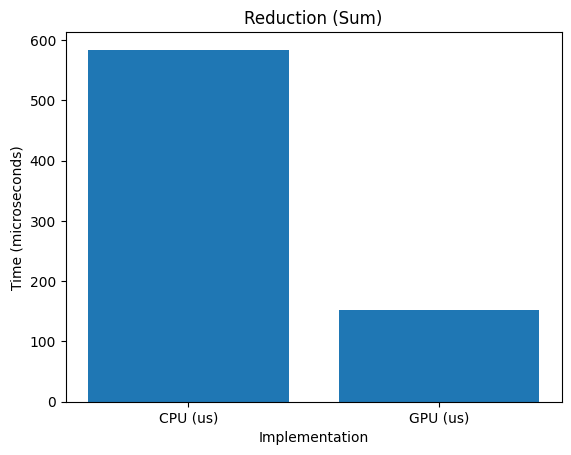

In [53]:
import matplotlib.pyplot as plt # библиотека для графиков

cpu_us = 584 # CPU time в microseconds
gpu_ms = 0.15136 # GPU time в milliseconds
gpu_us = gpu_ms * 1000 # переводит миллисекунды в микросекунды
labels = ["CPU (us)", "GPU (us)"] # подписи столбиков
times = [cpu_us, gpu_us] # значения времени

plt.figure() # создает график
plt.bar(labels, times) # строит столбчатый график
plt.xlabel("Implementation") # подпись оси X
plt.ylabel("Time (microseconds)") # подпись оси Y
plt.title("Reduction (Sum)") # заголовок
plt.show() # показывает график

### **Задание 4**


In [1]:
!apt-get update
!apt-get install -y openmpi-bin libopenmpi-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.8 kB]
Get:5 https://cli.github.com/packages stable/main amd64 Packages [356 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,309 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:8 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:13 https://ppa.launchpadcontent.

In [15]:
%%writefile task4.cpp

#include <mpi.h>            // подключает библиотеку MPI
#include <iostream>        // подключает ввод и вывод
#include <vector>       // подключает контейнер vector
#include <chrono>        // подключает работу со временем
using namespace std;       // чтобы не писать std::


int main(int argc, char** argv) {
    MPI_Init(&argc, &argv);         // инициализирует MPI-среду
    int rank = 0;                 // переменная для номера процесса
    int size = 0;                   // переменная для количества процессов
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);            // узнает номер текущего процесса
    MPI_Comm_size(MPI_COMM_WORLD, &size);              // узнает общее количество процессов
    int N = 1000000;                        // задает размер массива
    int local_n = N / size;            // считает, сколько элементов будет у каждого процесса
    vector<int> local_data(local_n);              // создает локальный массив для процесса
    vector<int> data;                  // объявляет общий массив

    if (rank == 0) {                 // если это главный процесс
        data.resize(N);                // выделяет память под массив
        for (int i = 0; i < N; i++) {                    // проходит по всему массиву
            data[i] = 1;                    // заполняет каждый элемент единицей
        }
    }

    MPI_Barrier(MPI_COMM_WORLD);                 // ждет, пока все процессы дойдут до этой точки
    auto start = chrono::high_resolution_clock::now();              // запоминает время начала
    MPI_Scatter(                     // распределяет массив между процессами
        data.data(),               // откуда отправлять данные (у rank 0)
        local_n,                   // сколько элементов отправить каждому процессу
        MPI_INT,                  // тип отправляемых данных
        local_data.data(),           // куда принимать данные
        local_n,                 // сколько элементов принять
        MPI_INT,                   // тип принимаемых данных
        0,                        // номер главного процесса
        MPI_COMM_WORLD           // коммуникатор
    );

    long long local_sum = 0;               // создает переменную для локальной суммы
    for (int i = 0; i < local_n; i++) {             // один процесс проходит по своему куску массива
        local_sum += local_data[i];              // прибавляет элемент к локальной сумме
    }

    long long global_sum = 0;            // переменная для итоговой суммы
    MPI_Reduce(                      // собирает локальные суммы
        &local_sum,               // что отправляет каждый процесс
        &global_sum,               // куда складывается итог (у rank 0)
        1,                      // количество элементов
        MPI_LONG_LONG,                // тип данных
        MPI_SUM,                   // операция суммирования
        0,                  // главный процесс
        MPI_COMM_WORLD             // коммуникатор
    );

    MPI_Barrier(MPI_COMM_WORLD);                   // синхронизирует процессы после вычислений
    auto end = chrono::high_resolution_clock::now();                // запоминает время окончания
    auto duration = chrono::duration_cast<chrono::microseconds>(end - start);               // считает время выполнения
    if (rank == 0) {                           // выводит результат только главный процесс
        cout << "MPI processes = " << size << endl;                      // выводит количество процессов
        cout << "Global sum = " << global_sum << endl;            // выводит итоговую сумму
        cout << "Time (microseconds) = " << duration.count() << endl;           // выводит время
    }

    MPI_Finalize();           // завершает работу MPI
    return 0;                     // завершает программу
}

Overwriting task4.cpp


In [16]:
!mpic++ task4.cpp -o task4

In [17]:
!mpirun --allow-run-as-root --oversubscribe -np 2 ./task4

MPI processes = 2
Global sum = 1000000
Time (microseconds) = 3066


In [18]:
!mpirun --allow-run-as-root --oversubscribe -np 4 ./task4

MPI processes = 4
Global sum = 1000000
Time (microseconds) = 4657


In [19]:
!mpirun --allow-run-as-root --oversubscribe -np 8 ./task4

MPI processes = 8
Global sum = 1000000
Time (microseconds) = 9242
